In [1]:
from numpy import array
import numpy
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import pandas as pd
from pandas import read_csv
from math import sqrt
from sklearn.metrics import mean_squared_error


c:\users\manel\appdata\local\programs\python\python36\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# fixem random seed
numpy.random.seed(7)

dadesSau = read_csv('dadesSau.csv', sep=';',header=0, index_col=0)
dataframe = pd.DataFrame(dadesSau.loc[dadesSau.index >= '2009-01-01']['Volum'])
dataset = dataframe.values
dataset = dataset.astype('float32')


In [3]:
# Normalitzem

scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
dataset = [item for sublist in dataset for item in sublist]


In [4]:
# transformem les dades a format seqüencia d'entrada i seqüencia de sortida
def split_sequence(sequence, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # check if we are beyond the sequence
        if out_end_ix > len(sequence):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)


In [5]:
def train_test (n_steps_in, n_steps_out, propTrainTest, dataset):
    
    n_steps_in, n_steps_out = n_steps_in, n_steps_out
    # split train test
    X, y = split_sequence(dataset, n_steps_in, n_steps_out)
    
    train_size = int(len(X) * propTrainTest)
    test_size = len(dataset) - train_size
    train_X, test_X = X[0:train_size,:], X[train_size:len(X),:]
    train_Y, test_Y = y[0:train_size,:], y[train_size:len(y),:]
    
    return (train_X, test_X, train_Y, test_Y)

In [6]:
n_steps_in = 30
n_steps_out = 15
propTrainTest = 0.8
trainX, testX, trainY, testY = train_test(n_steps_in, n_steps_out, propTrainTest, dataset)

Transformem l'entrada d'entrenament al format d'entrada de LSTM [samples,timesteps,features] En el nostre cas, univariant, features és 1 i samples i timesteps dependran del nombre de n_steps_in i n_steps_out

In [7]:
n_features = 1
train_X = trainX.reshape((trainX.shape[0], trainX.shape[1], n_features))
test_X = testX.reshape((testX.shape[0], testX.shape[1], n_features))

In [8]:
def evaluate_forecasts(actual, predicted):
    scores = list()
    # calculem RMSE per cada dia
    for i in range(actual.shape[1]):
        # calculem MSE
        mse = mean_squared_error(actual[:, i], predicted[:, i])
        # calculem RMSE
        rmse = sqrt(mse)
        # store
        scores.append(rmse)
    # calcul global de RMSE
    s = 0
    for row in range(actual.shape[0]):
        for col in range(actual.shape[1]):
            s += (actual[row, col] - predicted[row, col])**2
    score = sqrt(s / (actual.shape[0] * actual.shape[1]))
    return score, scores

In [19]:
model_list=[]
dense=[5,10,15,20,30,40,50,100,110,120,130,140,150,200,300,400,500]
epochs=[50,100,150,200,250,300,400,500,600,1000]
resultatsf=[]
for den in dense:
    resultat=[]
    for epoch in epochs:
        model = Sequential()
        model.add(LSTM(den, activation='sigmoid', input_shape=(n_steps_in, n_features)))
        model.add(Dense(n_steps_out))
        model.compile(optimizer='adam', loss='mse')
        # fit model
        model.fit(train_X, trainY, epochs=epoch, verbose=0)
        testPredict = model.predict(test_X)
        # invertim prediccions per tenir-les en l'escala original
        testPredict = scaler.inverse_transform(testPredict)
        test_YR = scaler.inverse_transform(testY)
        RMSE_TOT, RMSE_days = evaluate_forecasts(test_YR,testPredict)
        print(RMSE_TOT)
        resultat.append((den,epoch,RMSE_days,RMSE_TOT))
    
    resultatsf.append(resultat)


7.714817691724189
6.387031525761977
6.240025125603892
6.198728733405481
6.023972098597922
6.110119693398067
6.0415387386729265
6.1705913020041665
6.100765664268738
5.885460139724952
7.003627370336223
6.273826049494379
6.346245611297629
6.297157601106233
6.112698839550915
5.987492800059722
6.300740798626865
6.071728666823741
6.450535752414899
6.063241892277055
6.6967444420306315
6.2199559825607595
6.22853990725058
6.106203403715257
6.064461165069706
6.080109660812794
6.380281791141413
5.987328992322571
5.948336513288196
5.98170091945938
6.818592249992528
6.327373026101079
6.159903433504889
6.27660096525574
6.130555504505974
6.49910771407406
6.13116117112596
6.502441497593029
6.092222345995888
6.499316507633034
6.541812801400058
6.2919154945567835
6.076025586207737
6.771294312938859
6.678529788339978
6.027589100841378
5.949571109637984
5.953130257737958
6.42569599766792
6.5115195668170935
6.669082171480233
6.123001301996982
6.125831411601199
6.16443991453155
6.058601516403856
6.170140243

KeyboardInterrupt: 

In [28]:
model_list=[]
dense=[130,140,150,200,300,400,500]
epochs=[50,100,150,200,250,300,400,500,600,1000]
resultatsf=[]
for den in dense:
    resultat=[]
    for epoch in epochs:
        model = Sequential()
        model.add(LSTM(den, activation='sigmoid', input_shape=(n_steps_in, n_features)))
        model.add(Dense(n_steps_out))
        model.compile(optimizer='adam', loss='mse')
        # fit model
        model.fit(train_X, trainY, epochs=epoch, verbose=0)
        testPredict = model.predict(test_X)
        # invertim prediccions per tenir-les en l'escala original
        testPredict = scaler.inverse_transform(testPredict)
        test_YR = scaler.inverse_transform(testY)
        RMSE_TOT, RMSE_days = evaluate_forecasts(test_YR,testPredict)
        print(RMSE_TOT)
        resultat.append((den,epoch,RMSE_days,RMSE_TOT))
    
    resultatsf.append(resultat)

6.777300166219764
6.438469867777093
6.0418758335480005
6.271014143903094
6.611713263513959
6.542397276885758
7.246826137886103
7.5073272307722245
7.532716440536494
9.231778249268874
6.418288905819289
6.0863634646613765
6.555203310452176
6.127795981567934
6.984376794245863
6.927451069033071
7.545586201424896
7.063165880803507
8.181522384761687
9.336993311519786
6.369893167885117
6.538447542007102
6.246872208435268
6.281422003993978
6.44321265397172
7.030553401988426
7.059519660788347
7.80092927924101
7.8704861514358235
8.655417135459793
6.903177441120142
6.086287562055494
7.76075117996482
6.472309754887363
7.172866460266776
7.719703181476082
7.332487975183688
8.135939919504613
8.506757946953465
8.455425846184063
6.651536233010066


KeyboardInterrupt: 

In [29]:
model_list=[]
dense=[300,400,500]
epochs=[50,100,150,200,250,300,400,500,600,1000]
resultatsf=[]
for den in dense:
    resultat=[]
    for epoch in epochs:
        model = Sequential()
        model.add(LSTM(den, activation='sigmoid', input_shape=(n_steps_in, n_features)))
        model.add(Dense(n_steps_out))
        model.compile(optimizer='adam', loss='mse')
        # fit model
        model.fit(train_X, trainY, epochs=epoch, verbose=0)
        testPredict = model.predict(test_X)
        # invertim prediccions per tenir-les en l'escala original
        testPredict = scaler.inverse_transform(testPredict)
        test_YR = scaler.inverse_transform(testY)
        RMSE_TOT, RMSE_days = evaluate_forecasts(test_YR,testPredict)
        print(RMSE_TOT)
        resultat.append((den,epoch,RMSE_days,RMSE_TOT))
    
    resultatsf.append(resultat)

6.611981744452318
6.096436773130724
6.773510645704739
6.208322589415314
6.93637675732985


KeyboardInterrupt: 

In [1]:
llistaF = [(7.714817691724189,5, 50),
 (6.387031525761977,5, 100),
 (6.240025125603892,5, 150),
 (6.198728733405481,5, 200),
 (6.023972098597922,5, 250),
 (6.110119693398067,5, 300),
 (6.0415387386729265,5, 400),
 (6.1705913020041665,5, 500),
 (6.100765664268738,5, 600),
 (5.885460139724952,5, 1000),
 (7.003627370336223,10, 50),
 (6.273826049494379,10, 100),
 (6.346245611297629,10, 150),
 (6.297157601106233,10, 200),
 (6.112698839550915,10, 250),
 (5.987492800059722,10, 300),
 (6.300740798626865,10, 400),
 (6.071728666823741,10, 500),
 (6.450535752414899,10, 600),
 (6.063241892277055,10, 1000),
 (6.6967444420306315,15, 50),
 (6.2199559825607595,15, 100),
 (6.22853990725058,15, 150),
 (6.106203403715257,15, 200),
 (6.064461165069706,15, 250),
 (6.080109660812794,15, 300),
 (6.380281791141413,15, 400),
 (5.987328992322571,15, 500),
 (5.948336513288196,15, 600),
 (5.98170091945938,15, 1000),
 (6.818592249992528,20, 50),
 (6.327373026101079,20, 100),
 (6.159903433504889,20, 150),
 (6.27660096525574,20, 200),
 (6.130555504505974,20, 250),
 (6.49910771407406,20, 300),
 (6.13116117112596,20, 400),
 (6.502441497593029,20, 500),
 (6.092222345995888,20, 600),
 (6.499316507633034,20, 1000),
 (6.541812801400058,30, 50),
 (6.2919154945567835,30, 100),
 (6.076025586207737,30, 150),
 (6.771294312938859,30, 200),
 (6.678529788339978,30, 250),
 (6.027589100841378,30, 300),
 (5.949571109637984,30, 400),
 (5.953130257737958,30, 500),
 (6.42569599766792,30, 600),
 (6.5115195668170935,30, 1000),
 (6.669082171480233,40, 50),
 (6.123001301996982,40, 100),
 (6.125831411601199,40, 150),
 (6.16443991453155,40, 200),
 (6.058601516403856,40, 250),
 (6.170140243697672,40, 300),
 (6.399166065057516,40, 400),
 (6.520388145786249,40, 500),
 (6.475858842820276,40, 600),
 (6.959772494233454,40, 1000),
 (6.611002199329368,50, 50),
 (6.141949084414373,50, 100),
 (6.986007415435962,50, 150),
 (6.072978091734561,50, 200),
 (6.009546196004776,50, 250),
 (6.269404481649623,50, 300),
 (6.193337529298981,50, 400),
 (6.621340841621027,50, 500),
 (6.908035263196567,50, 600),
 (8.404251247995171,50, 1000),
 (7.059407134291098,100, 50),
 (6.037885332300836,100, 100),
 (5.983903583798628,100, 150),
 (6.187647434808802,100, 200),
 (6.246038399541264,100, 250),
 (6.0702053359587,100, 300),
 (7.349726397466462,100, 400),
 (8.068253688759114,100, 500),
 (8.634666384572474,100, 600),
 (8.366379898132434,100, 1000),
 (6.5772646546747815,110, 50),
 (7.226481791184351,110, 100),
 (6.410682991220339,110, 150),
 (5.989455412307928,110, 200),
 (6.267358060125066,110, 250),
 (6.700053013984177,110, 300),
 (7.417305274635736,110, 400),
 (7.1575004554639285,110, 500),
 (7.778353673509681,110, 600),
 (8.714617741065831,110, 1000),
 (7.050284890855997,120, 50),
 (6.102661803505365,120, 100),
 (6.064551953586054,120, 150),
 (6.837350379533742,120, 200),
 (6.809012538486644,120, 250),
 (6.440712043176917,120, 300),
 (8.424236930876573,120, 400),
 (7.871916708839205,120, 500),
 (7.964147054226272,120, 600),
 (8.927229571527098,120, 1000),
 (6.777300166219764,130, 50),
 (6.438469867777093,130, 100),
 (6.0418758335480005,130, 150),
 (6.271014143903094,130, 200),
 (6.611713263513959,130, 250),
 (6.542397276885758,130, 300),
 (7.246826137886103,130, 400),
 (7.5073272307722245,130, 500),
 (7.532716440536494,130, 600),
 (9.231778249268874,130, 1000),
 (6.418288905819289,140, 50),
 (6.0863634646613765,140, 100),
 (6.555203310452176,140, 150),
 (6.127795981567934,140, 200),
 (6.984376794245863,140, 250),
 (6.927451069033071,140, 300),
 (7.545586201424896,140, 400),
 (7.063165880803507,140, 500),
 (8.181522384761687,140, 600),
 (9.336993311519786,140, 1000),
 (6.369893167885117,150, 50),
 (6.538447542007102,150, 100),
 (6.246872208435268,150, 150),
 (6.281422003993978,150, 200),
 (6.44321265397172,150, 250),
 (7.030553401988426,150, 300),
 (7.059519660788347,150, 400),
 (7.80092927924101,150, 500),
 (7.8704861514358235,150, 600),
 (8.655417135459793,150, 1000),
 (6.903177441120142,200, 50),
 (6.086287562055494,200, 100),
 (7.76075117996482,200, 150),
 (6.472309754887363,200, 200),
 (7.172866460266776,200, 250),
 (7.719703181476082,200, 300),
 (7.332487975183688,200, 400),
 (8.135939919504613,200, 500),
 (8.506757946953465,200, 600),
 (8.455425846184063,200, 1000),
 (6.651536233010066,300, 50),
 (6.611981744452318,300, 50),
 (6.096436773130724,300, 100),
 (6.773510645704739,300, 150),
 (6.208322589415314,300, 200),
 (6.93637675732985,300, 250)]

In [12]:
a = []
for i in llistaF:
    a.append((i[1],i[2],i[0]))

#resultatsEpDe = pd.DataFrame(resultatsf)

In [6]:
import pandas as pd
varlist = []
    
resultFinal = pd.DataFrame(a)
resultFinal.columns=['Neurones LSTM','epochs', 'RMSE global']
resultFinal = resultFinal.sort_values(by='RMSE global', ascending=True)
resultFinal = resultFinal.reset_index(drop=True)

resultFinal[0:15]

,Neurones LSTM,epochs,RMSE global
0,5,1000,5.885460
1,15,600,5.948337
2,30,400,5.949571
3,30,500,5.953130
4,15,1000,5.981701
5,100,150,5.983904
6,15,500,5.987329
7,10,300,5.987493
8,110,200,5.989455
9,50,250,6.009546


In [33]:
model = Sequential()
model.add(LSTM(5, activation='sigmoid', input_shape=(n_steps_in, n_features)))
model.add(Dense(n_steps_out))
model.compile(optimizer='adam', loss='mse')
# fit model
model.fit(train_X, trainY, epochs=1000, verbose=0)


5.855999251321899


In [36]:
testPredict = model.predict(test_X)
# invertim prediccions per tenir-les en l'escala original
testPredict = scaler.inverse_transform(testPredict)
test_YR = scaler.inverse_transform(testY)
RMSE_TOT, RMSE_days = evaluate_forecasts(test_YR,testPredict)
print(RMSE_TOT)

5.855999251321899


In [37]:
from tabulate import tabulate
headers=[]
for i in range(len(RMSE_days)):
    headers.append('dia '+str(i+1))

print(RMSE_days)
headers.append('Total')
v = RMSE_days
ultim = v.append(RMSE_TOT)
table1 = tabulate([RMSE_days[0:5]], headers[0:5], tablefmt="fancy_grid")
table2 = tabulate([RMSE_days[5:10]], headers[5:10], tablefmt="fancy_grid")
table3 = tabulate([RMSE_days[10:16]], headers[10:16], tablefmt="fancy_grid")
#output
print(table1)
print(table2)
print(table3)

[1.3362274301476678, 2.0904868589187573, 2.779092444744645, 3.430611522868394, 4.085917660608503, 4.683900188382695, 5.168635065168526, 5.649360802876649, 6.165482312816914, 6.60534862767773, 7.054517708020403, 7.423063484201015, 7.865697785966369, 8.263875217230536, 8.649067787697781]
╒═════════╤═════════╤═════════╤═════════╤═════════╕
│   dia 1 │   dia 2 │   dia 3 │   dia 4 │   dia 5 │
╞═════════╪═════════╪═════════╪═════════╪═════════╡
│ 1.33623 │ 2.09049 │ 2.77909 │ 3.43061 │ 4.08592 │
╘═════════╧═════════╧═════════╧═════════╧═════════╛
╒═════════╤═════════╤═════════╤═════════╤══════════╕
│   dia 6 │   dia 7 │   dia 8 │   dia 9 │   dia 10 │
╞═════════╪═════════╪═════════╪═════════╪══════════╡
│  4.6839 │ 5.16864 │ 5.64936 │ 6.16548 │  6.60535 │
╘═════════╧═════════╧═════════╧═════════╧══════════╛
╒══════════╤══════════╤══════════╤══════════╤══════════╤═════════╕
│   dia 11 │   dia 12 │   dia 13 │   dia 14 │   dia 15 │   Total │
╞══════════╪══════════╪══════════╪══════════╪═════════

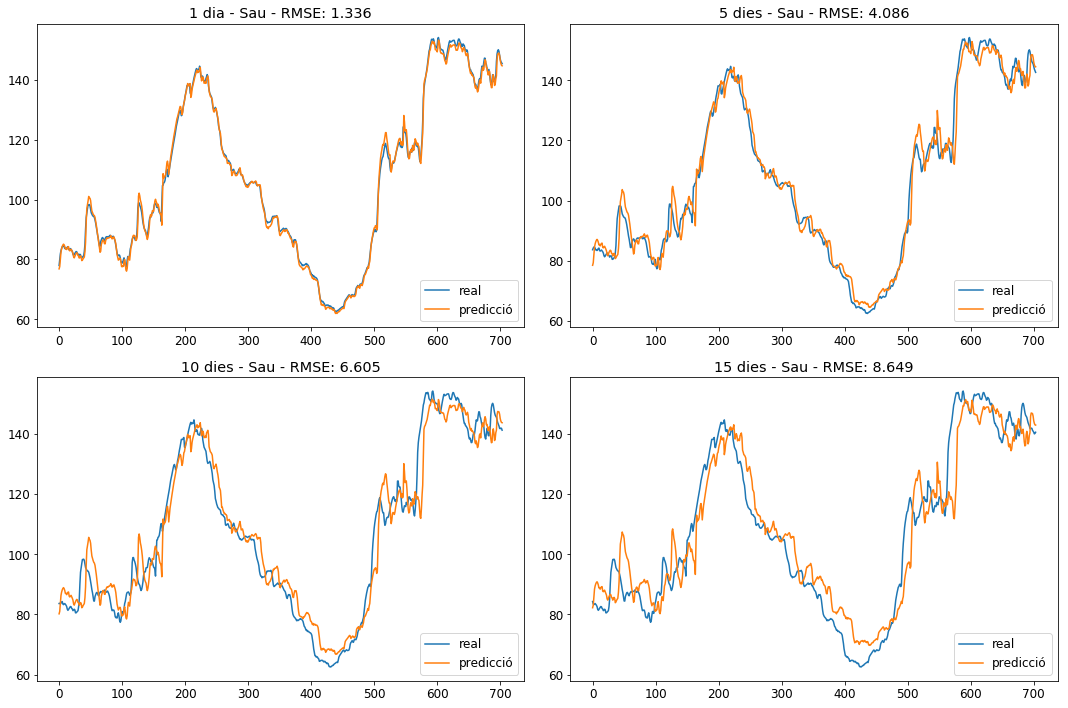

In [39]:
import matplotlib.pyplot as plt
dies = list()
    # calculem RMSE per cada dia
    
for i in range(test_YR.shape[1]):
    # calculem MSE
    dies.append((test_YR[:, i], testPredict[:, i]))

%matplotlib inline
plt.rcParams["figure.figsize"] = [15,10]
title1 = '1 dia - Sau - RMSE: '+str(round(RMSE_days[0],3))
title5 = '5 dies - Sau - RMSE: '+str(round(RMSE_days[4],3))
title10 = '10 dies - Sau - RMSE: '+str(round(RMSE_days[9],3))
title15 = '15 dies - Sau - RMSE: '+str(round(RMSE_days[14],3))

plt.rcParams.update({'font.size': 12})

plt.subplots_adjust(hspace=0.5)

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))

# plot time signal:
axes[0, 0].set_title(title1)
axes[0, 0].plot(dies[0][0], label='real')
axes[0, 0].plot(dies[0][1], label='predicció')
axes[0, 0].legend(loc=4)

axes[0, 1].set_title(title5)
axes[0, 1].plot(dies[4][0], label='real')
axes[0, 1].plot(dies[4][1], label='predicció')
axes[0, 1].legend(loc=4)

axes[1, 0].set_title(title10)
axes[1, 0].plot(dies[9][0], label='real')
axes[1, 0].plot(dies[9][1], label='predicció')
axes[1, 0].legend(loc=4)

axes[1, 1].set_title(title15)
axes[1, 1].plot(dies[14][0], label='real')
axes[1, 1].plot(dies[14][1], label='predicció')
axes[1, 1].legend(loc=4)


fig.tight_layout()
plt.show()


In [ ]:
from scipy.stats import uniform
from scipy.stats import randint
dense=[]
epochs=[]
lr=[]
batch=[]
num_repeticions=100

for i in range(num_repeticions):
    dense.append(randint.rvs(5, 500))
    epochs.append(randint.rvs(50, 1200))
    lr.append(uniform.rvs(0.0001, 0.01))
    batch.append(randint.rvs(8, 128))

In [ ]:
#Simulació RandomizedSearchCV per SVM
resultat=[]

for den, epoch, l_r, bat in zip(dense, epochs, lr, batch):
    adam = optimizers.Adam(lr=l_r)
    model = Sequential()
    model.add(LSTM(den, activation='sigmoid', input_shape=(n_steps_in, n_features)))
    model.add(Dense(n_steps_out))
    model.compile(optimizer=adam, loss='mse')
    # fit model
    model.fit(train_X, trainY, epochs=epoch, batch_size=bat, n_jobs=-1, verbose=0)
    testPredict = model.predict(test_X)
    # invertim prediccions per tenir-les en l'escala original
    testPredict = scaler.inverse_transform(testPredict)
    test_YR = scaler.inverse_transform(testY)
    RMSE_TOT, RMSE_days = evaluate_forecasts(test_YR,testPredict)
    print(RMSE_TOT,den, epoch, l_r, bat)
    presultat.append((den, epoch, l_r, bat, RMSE_days,RMSE_TOT))

In [ ]:
model = Sequential()
model.add(LSTM(100, activation='sigmoid', input_shape=(n_steps_in, n_features)))
#model.add(LSTM(100, activation='sigmoid'))
model.add(Dense(n_steps_out))
model.compile(optimizer='adam', loss='mse')
# fit model
model.fit(train_X, trainY, epochs=100, verbose=0)

In [9]:
# prediccions
trainPredict = model.predict(train_X)
testPredict = model.predict(test_X)
# invertim prediccions per tenir-les en l'escala original
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform(trainY)
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform(testY)


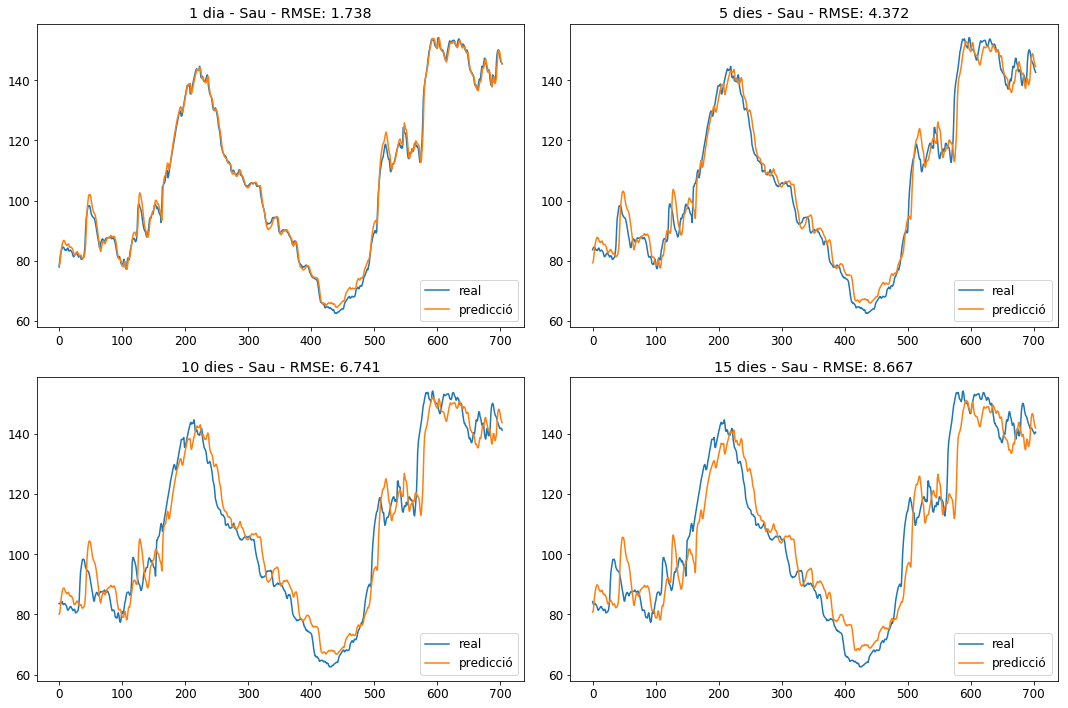

In [20]:
plt.rcParams.update({'font.size': 12})

plt.subplots_adjust(hspace=0.5)

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))

# plot time signal:
axes[0, 0].set_title(title1)
axes[0, 0].plot(dies[0][0], label='real')
axes[0, 0].plot(dies[0][1], label='predicció')
axes[0, 0].legend(loc=4)

axes[0, 1].set_title(title5)
axes[0, 1].plot(dies[4][0], label='real')
axes[0, 1].plot(dies[4][1], label='predicció')
axes[0, 1].legend(loc=4)

axes[1, 0].set_title(title10)
axes[1, 0].plot(dies[9][0], label='real')
axes[1, 0].plot(dies[9][1], label='predicció')
axes[1, 0].legend(loc=4)

axes[1, 1].set_title(title15)
axes[1, 1].plot(dies[14][0], label='real')
axes[1, 1].plot(dies[14][1], label='predicció')
axes[1, 1].legend(loc=4)


fig.tight_layout()
plt.show()

In [10]:
import numpy as np
from keras import optimizers
model_list=[]
lr=np.arange(0.0001,0.01,0.0005)
batch=[8,16,32,64,128]
resultatsf=[]
for learn in lr:
    adam = optimizers.Adam(lr=learn)
    resultat=[]
    for batch_size in batch:
        model = Sequential()
        model.add(LSTM(5, activation='sigmoid', input_shape=(n_steps_in, n_features)))
        model.add(Dense(n_steps_out))
        model.compile(optimizer='adam', loss='mse')
        # fit model
        model.fit(train_X, trainY, epochs=1000, verbose=0)
        testPredict = model.predict(test_X)
        # invertim prediccions per tenir-les en l'escala original
        testPredict = scaler.inverse_transform(testPredict)
        test_YR = scaler.inverse_transform(testY)
        RMSE_TOT, RMSE_days = evaluate_forecasts(test_YR,testPredict)
        print(RMSE_TOT)
        resultat.append((learn,batch_size,RMSE_days,RMSE_TOT))    
    resultatsf.append(resultat)

5.964593789574174
5.873251766862027
6.007504458034778
5.882240602935399
5.877045462827832


KeyboardInterrupt: 

S'afegeixen resultats calculats en la màquina virtual.

In [7]:
res_lr_bs=[(5.964593789574174,0.0001,8),
(5.873251766862027,0.0001,16),
(6.007504458034778,0.0001,32),
(5.882240602935399,0.0001,64),
(5.877045462827832,0.0001,128),
(5.77831900641409,0.0005,8),
(5.97276217921763,0.0005,16),
(5.940690477509206,0.0005,32),
(5.849986898200291,0.0005,64),
(6.095043533635578,0.0005,128),
(6.185322587257638,0.001,8),
(5.950311200021867,0.001,16),
(5.971359750466825,0.001,32),
(5.976684477514754,0.001,64),
(5.89015143660494,0.001,128),
(6.00229366405416,0.0015,8),
(5.927314115613037,0.0015,16),
(5.834306588946179,0.0015,32),
(5.86932884796817,0.0015,64),
(5.889104378990481,0.0015,128),
(6.01347656315115,0.002,8),
(5.854973316382331,0.002,16),
(6.059334452073568,0.002,32),
(5.935074346733078,0.002,64),
(5.865241465440319,0.002,128),
(6.021220614481145,0.0025,8),
(6.033802546725691,0.0025,16),
(5.94559848992629,0.0025,32),
(5.81120084395983,0.0025,64),
(5.9646120719433835,0.0025,128),
(6.0907939160523,0.003,8),
(5.970187048213177,0.003,16),
(5.833301895639611,0.003,32),
(6.073687908390293,0.003,64),
(5.903914525030891,0.003,128),
(5.89853391363912,0.0035,8),
(5.954211910190632,0.0035,16),
(5.816001259492177,0.0035,32),
(5.876498175408622,0.0035,64),
(5.992794654642428,0.0035,128),
(5.818976869641058,0.004,8),
(5.901337921549856,0.004,16),
(5.999739547317003,0.004,32),
(5.851164177231656,0.004,64),
(5.807710742227351,0.004,128),
(5.94899192374441,0.0045000000000000005,8),
(6.027620597563546,0.0045000000000000005,16),
(5.947956608974199,0.0045000000000000005,32),
(5.918509028040513,0.0045000000000000005,64),
(5.744475497486064,0.0045000000000000005,128),
(5.814394229023026,0.005000000000000001,8),
(6.177283928510987,0.005000000000000001,16),
(5.9311513464554855,0.005000000000000001,32),
(5.924133411915735,0.005000000000000001,64),
(6.020356673926307,0.005000000000000001,128),
(5.865379644574197,0.0055,8),
(5.87365670266024,0.0055,16),
(6.209455598706007,0.0055,32),
(6.031754093661572,0.0055,64),
(5.956662835668328,0.0055,128),
(5.888414661033422,0.006,8),
(6.03204099042565,0.006,16),
(5.888836503777493,0.006,32),
(6.0044431507840255,0.006,64),
(5.949174513095754,0.006,128),
(5.887579219244403,0.006500000000000001,8),
(5.909117681307327,0.006500000000000001,16),
(5.894815784901879,0.006500000000000001,32),
(6.088389684144307,0.006500000000000001,64)]


In [9]:
import pandas as pd
a = []
for i in res_lr_bs:
    a.append((i[1],i[2],i[0]))

varlist = []
    
resultFinal_lb = pd.DataFrame(a)
resultFinal_lb.columns=['learning rate','batch size', 'RMSE global']
resultFinal_lb = resultFinal_lb.sort_values(by='RMSE global', ascending=True)
resultFinal_lb = resultFinal_lb.reset_index(drop=True)

resultFinal_lb[0:15]

,learning rate,batch size,RMSE global
0,0.0045,128,5.744475
1,0.0005,8,5.778319
2,0.0040,128,5.807711
3,0.0025,64,5.811201
4,0.0050,8,5.814394
5,0.0035,32,5.816001
6,0.0040,8,5.818977
7,0.0030,32,5.833302
8,0.0015,32,5.834307
9,0.0005,64,5.849987


In [14]:
from keras import optimizers
adam = optimizers.Adam(lr=0.0045)
model = Sequential()
model.add(LSTM(5, activation='sigmoid', input_shape=(n_steps_in, n_features)))
model.add(Dense(n_steps_out))
model.compile(optimizer=adam, loss='mse')
# fit model
model.fit(train_X, trainY, epochs=1000, batch_size=128, verbose=0)

In [15]:
# prediccions
trainPredict = model.predict(train_X)
testPredict = model.predict(test_X)
# invertim prediccions per tenir-les en l'escala original
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform(trainY)
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform(testY)

In [16]:
RMSE_TOT, RMSE_days = evaluate_forecasts(testY,testPredict)
print(RMSE_TOT)

5.800467930306714


In [17]:
from tabulate import tabulate
headers=[]
for i in range(len(RMSE_days)):
    headers.append('step '+str(i+1))


table1 = tabulate([RMSE_days[0:10]], headers, tablefmt="fancy_grid")
table2 = tabulate([RMSE_days[10:15]], headers[10:15], tablefmt="fancy_grid")
#output
print(table1)
print(table2)

╒══════════╤══════════╤══════════╤══════════╤══════════╤══════════╤══════════╤══════════╤══════════╤═══════════╕
│   step 1 │   step 2 │   step 3 │   step 4 │   step 5 │   step 6 │   step 7 │   step 8 │   step 9 │   step 10 │
╞══════════╪══════════╪══════════╪══════════╪══════════╪══════════╪══════════╪══════════╪══════════╪═══════════╡
│  1.02489 │  1.96899 │  2.73589 │  3.37346 │  3.98359 │  4.56923 │  5.09556 │  5.66452 │  6.10558 │   6.59507 │
╘══════════╧══════════╧══════════╧══════════╧══════════╧══════════╧══════════╧══════════╧══════════╧═══════════╛
╒═══════════╤═══════════╤═══════════╤═══════════╤═══════════╕
│   step 11 │   step 12 │   step 13 │   step 14 │   step 15 │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══════════╡
│   7.01549 │    7.4004 │   7.84256 │   8.16217 │   8.55613 │
╘═══════════╧═══════════╧═══════════╧═══════════╧═══════════╛


In [18]:
dies = list()
    # calculem RMSE per cada dia
    
for i in range(testY.shape[1]):
    # calculem MSE
    dies.append((testY[:, i], testPredict[:, i]))

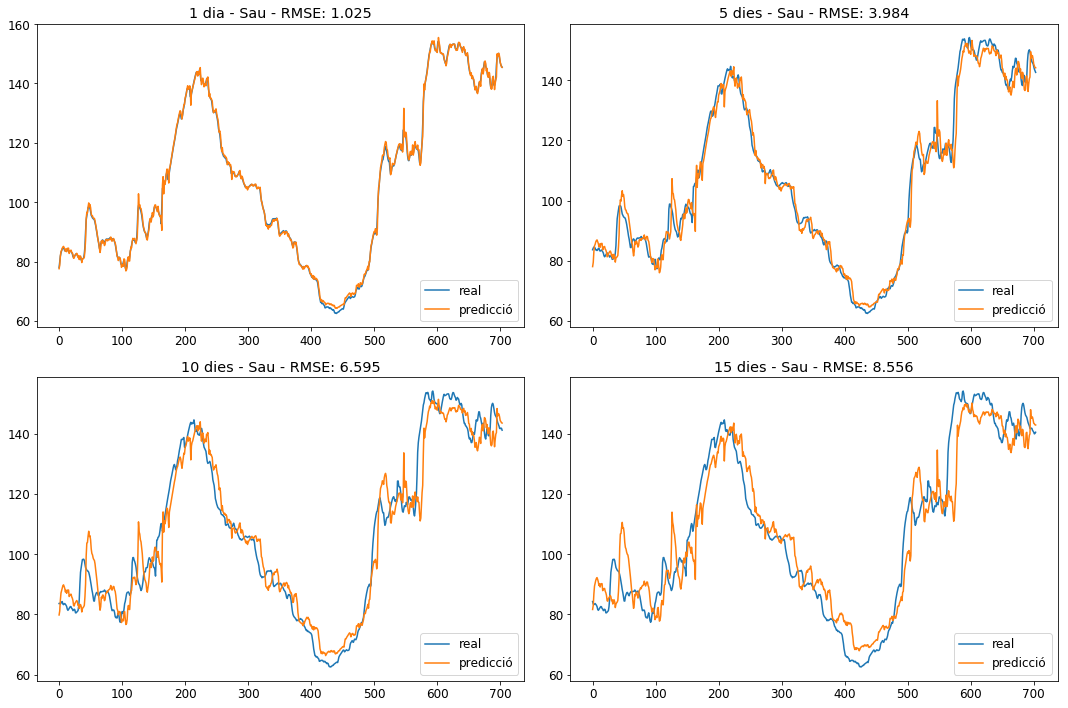

In [19]:
%matplotlib inline
plt.rcParams["figure.figsize"] = [15,10]
plt.rcParams.update({'font.size': 12})
title1 = '1 dia - Sau - RMSE: '+str(round(RMSE_days[0],3))
title5 = '5 dies - Sau - RMSE: '+str(round(RMSE_days[4],3))
title10 = '10 dies - Sau - RMSE: '+str(round(RMSE_days[9],3))
title15 = '15 dies - Sau - RMSE: '+str(round(RMSE_days[14],3))

plt.rcParams.update({'font.size': 12})

plt.subplots_adjust(hspace=0.5)

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))

# plot time signal:
axes[0, 0].set_title(title1)
axes[0, 0].plot(dies[0][0], label='real')
axes[0, 0].plot(dies[0][1], label='predicció')
axes[0, 0].legend(loc=4)

axes[0, 1].set_title(title5)
axes[0, 1].plot(dies[4][0], label='real')
axes[0, 1].plot(dies[4][1], label='predicció')
axes[0, 1].legend(loc=4)

axes[1, 0].set_title(title10)
axes[1, 0].plot(dies[9][0], label='real')
axes[1, 0].plot(dies[9][1], label='predicció')
axes[1, 0].legend(loc=4)

axes[1, 1].set_title(title15)
axes[1, 1].plot(dies[14][0], label='real')
axes[1, 1].plot(dies[14][1], label='predicció')
axes[1, 1].legend(loc=4)


fig.tight_layout()
plt.show()

In [9]:
n_steps_out = 15
propTrainTest = 0.8
trainX, testX, trainY, testY = train_test(n_steps_in, n_steps_out, propTrainTest, dataset)

n_features = 1
train_X = trainX.reshape((trainX.shape[0], trainX.shape[1], n_features))
test_X = testX.reshape((testX.shape[0], testX.shape[1], n_features))

In [12]:
from keras import optimizers
import numpy as np
adam = optimizers.Adam(lr=0.0045)
n_steps_in = np.arange(5,51,1)
resultat = []

for entrades in n_steps_in:

    trainX, testX, trainY, testY = train_test(entrades, n_steps_out, propTrainTest, dataset)
    n_features = 1
    train_X = trainX.reshape((trainX.shape[0], trainX.shape[1], n_features))
    test_X = testX.reshape((testX.shape[0], testX.shape[1], n_features))
    model = Sequential()
    model.add(LSTM(5, activation='sigmoid', input_shape=(entrades, n_features)))
    model.add(Dense(n_steps_out))
    model.compile(optimizer=adam, loss='mse')
    # fit model
    model.fit(train_X, trainY, epochs=1000, batch_size=128, verbose=0)
    testPredict = model.predict(test_X)
    # invertim prediccions per tenir-les en l'escala original
    testPredict = scaler.inverse_transform(testPredict)
    test_YR = scaler.inverse_transform(testY)
    RMSE_TOT, RMSE_days = evaluate_forecasts(test_YR,testPredict)
    print(RMSE_TOT)
    resultat.append((entrades, RMSE_TOT))    

5.846195201443118
5.9224398629396875
5.803178920403446
5.890238803309531
5.8393334568366475
5.987742065312922
5.910607656967401
5.853122721106725
5.810311741689859
6.057110792001968
5.928511846131018
6.041434905678325
6.001281107897189
5.960274058729509
6.034245116679252
5.867632019855071
5.929653618368262
5.984665536669333
5.940633641572348
5.832571302201433
5.91350664561585
5.931901470316517
5.815675751446767
6.305365334652576
5.948274777000419
5.836225969640213
5.950733196800893
5.822185569870384
6.193908683200962
6.391559674626369
5.903942746813419
5.913808078015777
6.206066246899136
5.863525895285088
6.003490259566917
10.351200606470888
5.904150415363164
6.120706270311747
5.738001389935018
5.779908718798635
6.194895348378299
5.637231929023655
7.121171361056582
5.781977648450358
5.904346432252282
5.856846195240626


In [13]:
import pandas as pd
    
resultFinal_e = pd.DataFrame(resultat)
resultFinal_e.columns=['n entrades', 'RMSE global']
resultFinal_e = resultFinal_e.sort_values(by='RMSE global', ascending=True)
resultFinal_e = resultFinal_e.reset_index(drop=True)

resultFinal_e[0:15]

,n entrades,RMSE global
0,46,5.637232
1,43,5.738001
2,44,5.779909
3,48,5.781978
4,7,5.803179
5,13,5.810312
6,27,5.815676
7,32,5.822186
8,24,5.832571
9,30,5.836226


In [12]:
from keras import optimizers

n_steps_out = 15
n_steps_in = 30
propTrainTest = 0.8
trainX, testX, trainY, testY = train_test(n_steps_in, n_steps_out, propTrainTest, dataset)

n_features = 1
train_X = trainX.reshape((trainX.shape[0], trainX.shape[1], n_features))
test_X = testX.reshape((testX.shape[0], testX.shape[1], n_features))

adam = optimizers.Adam(lr=0.0045)
model = Sequential()
model.add(LSTM(5, activation='sigmoid', input_shape=(n_steps_in, n_features)))
model.add(Dense(n_steps_out))
model.compile(optimizer=adam, loss='mse')
# fit model
model.fit(train_X, trainY, epochs=1000, batch_size=128, verbose=0)
testPredict = model.predict(test_X)
# invertim prediccions per tenir-les en l'escala original
testPredict = scaler.inverse_transform(testPredict)
test_YR = scaler.inverse_transform(testY)
RMSE_TOT, RMSE_days = evaluate_forecasts(test_YR,testPredict)
print(RMSE_TOT)   

6.749289647917021
5.870202373007372
5.98349264367819
6.266418214784283
5.888198237674166
6.510676064624996
5.8442679708722665
5.888363056119105
6.207465663751961
5.911677453756238
5.934089176001737
6.769647090858596
5.835775074225901
6.014237422468855
6.2544136557924705
5.806447018812763


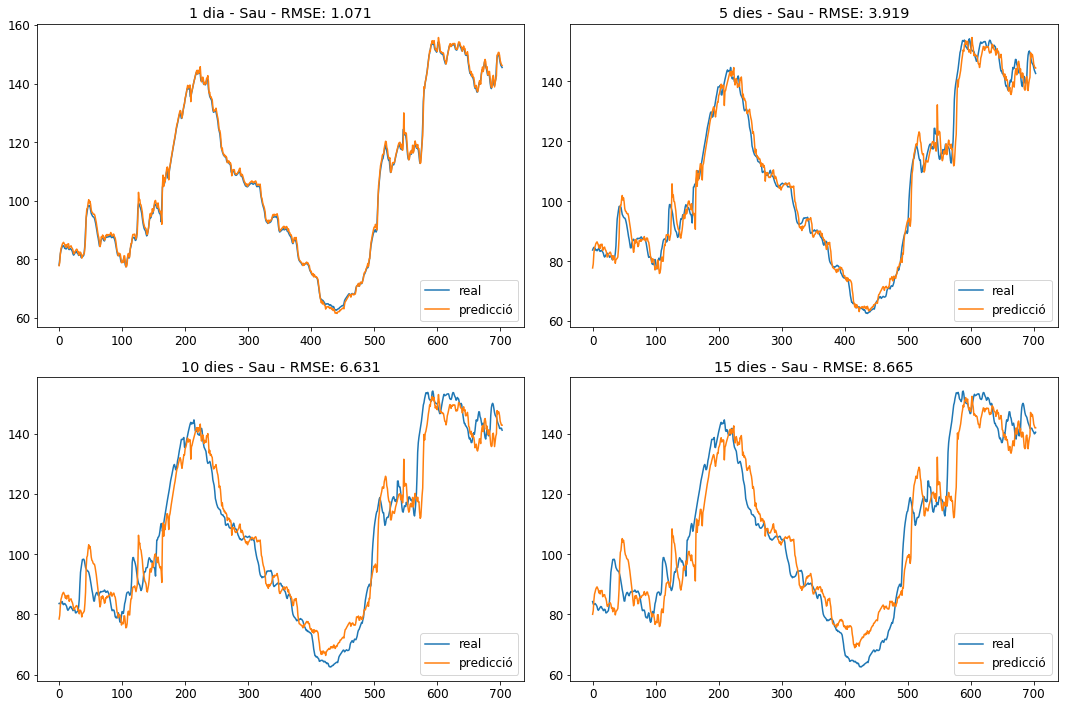

In [14]:
dies = list()
    # calculem RMSE per cada dia
    
for i in range(test_YR.shape[1]):
    # calculem MSE
    dies.append((test_YR[:, i], testPredict[:, i]))

%matplotlib inline
plt.rcParams["figure.figsize"] = [15,10]
plt.rcParams.update({'font.size': 12})
title1 = '1 dia - Sau - RMSE: '+str(round(RMSE_days[0],3))
title5 = '5 dies - Sau - RMSE: '+str(round(RMSE_days[4],3))
title10 = '10 dies - Sau - RMSE: '+str(round(RMSE_days[9],3))
title15 = '15 dies - Sau - RMSE: '+str(round(RMSE_days[14],3))

plt.rcParams.update({'font.size': 12})

plt.subplots_adjust(hspace=0.5)

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))

# plot time signal:
axes[0, 0].set_title(title1)
axes[0, 0].plot(dies[0][0], label='real')
axes[0, 0].plot(dies[0][1], label='predicció')
axes[0, 0].legend(loc=4)

axes[0, 1].set_title(title5)
axes[0, 1].plot(dies[4][0], label='real')
axes[0, 1].plot(dies[4][1], label='predicció')
axes[0, 1].legend(loc=4)

axes[1, 0].set_title(title10)
axes[1, 0].plot(dies[9][0], label='real')
axes[1, 0].plot(dies[9][1], label='predicció')
axes[1, 0].legend(loc=4)

axes[1, 1].set_title(title15)
axes[1, 1].plot(dies[14][0], label='real')
axes[1, 1].plot(dies[14][1], label='predicció')
axes[1, 1].legend(loc=4)


fig.tight_layout()
plt.show()

In [15]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
def evaluate_forecasts_rquad(actual, predicted):
    scores = list()
    # calculem RMSE per cada dia
    for i in range(actual.shape[1]):
        # calculem MSE
        mse = mean_squared_error(actual[:, i], predicted[:, i])
        r_quad = r2_score(actual[:, i], predicted[:, i])
        mae = mean_absolute_error(actual[:, i], predicted[:, i])
        # calculem RMSE
        rmse = sqrt(mse)
        # store
        scores.append((rmse,r_quad,mae,mse))
    # calcul global de RMSE
    s = 0
    r = 0
    for row in range(actual.shape[0]):
        for col in range(actual.shape[1]):
            s += (actual[row, col] - predicted[row, col])**2
    score = sqrt(s / (actual.shape[0] * actual.shape[1]))
    return score, scores

In [16]:
RMSE_TOT, RMSE_days = evaluate_forecasts_rquad(test_YR,testPredict)
global_y = test_YR.reshape((test_YR.shape[0]*test_YR.shape[1], 1))
global_pred = testPredict.reshape((testPredict.shape[0]*testPredict.shape[1], 1))
r_quad = r2_score(global_y, global_pred)
rmse = sqrt(mean_squared_error(global_y, global_pred))
mse = mean_squared_error(global_y, global_pred)
mae = mean_absolute_error(global_y, global_pred)

res_globals=[rmse, r_quad, mae, mse]

resultsDF =  pd.DataFrame(RMSE_days)
resultsDF = resultsDF.T
resultsDF['Global'] = res_globals
resultsDF.columns=['dia 1','dia 2','dia 3','dia 4','dia 5','dia 6','dia 7','dia 8','dia 9','dia 10','dia 11','dia 12','dia 13','dia 14','dia 15', 'global']
resultsDF.rename(index={0:'RMSE',1:'R2',2:'MAE', 3:'MSE'}, inplace=True)
resultsDF = resultsDF.round(4)
display(resultsDF)

,dia 1,dia 2,dia 3,dia 4,dia 5,dia 6,dia 7,dia 8,dia 9,dia 10,dia 11,dia 12,dia 13,dia 14,dia 15,global
RMSE,1.0711,1.8334,2.5920,3.2664,3.9193,4.5319,5.0570,5.5775,6.1555,6.6308,7.0079,7.4598,7.8352,8.2553,8.6653,5.8064
R2,0.9984,0.9954,0.9909,0.9856,0.9793,0.9723,0.9656,0.9582,0.9491,0.9410,0.9342,0.9255,0.9179,0.9090,0.8998,0.9546
MAE,0.8096,1.2569,1.7993,2.2640,2.7307,3.1953,3.5909,4.0322,4.5827,5.0013,5.3140,5.7323,6.0410,6.4399,6.7872,3.9718
MSE,1.1474,3.3613,6.7186,10.6695,15.3610,20.5386,25.5730,31.1085,37.8900,43.9674,49.1109,55.6479,61.3906,68.1503,75.0875,33.7148


In [17]:
RMSE_TOT, RMSE_days = evaluate_forecasts(test_YR,testPredict)
v = RMSE_days
ultim = v.append(RMSE_TOT)

dades_diesDF=pd.DataFrame(v)
dades_diesDF=dades_diesDF.round(3)
dades_diesDF=dades_diesDF.T
dades_diesDF.columns=['dia 1','dia 2','dia 3','dia 4','dia 5','dia 6','dia 7','dia 8','dia 9','dia 10','dia 11','dia 12','dia 13','dia 14','dia 15', 'global']
dades_diesDF.rename(index={0:'RMSE'}, inplace=True)

display(dades_diesDF)

,dia 1,dia 2,dia 3,dia 4,dia 5,dia 6,dia 7,dia 8,dia 9,dia 10,dia 11,dia 12,dia 13,dia 14,dia 15,global
RMSE,1.071,1.833,2.592,3.266,3.919,4.532,5.057,5.577,6.155,6.631,7.008,7.46,7.835,8.255,8.665,5.806


In [18]:
resultsDF.to_csv('lstm-uni-sau.csv', sep=',', encoding='utf-8')

In [19]:
resultatsDEF=[]
for i, j in zip (test_YR, testPredict):
    resultatsDEF.append((i,j))
    
resultatsDEF = pd.DataFrame(resultatsDEF)
resultatsDEF.columns=['ytest','predict']
resultatsDEF.to_csv('lstm-uni-sau-test-predict.csv', sep=',', encoding='utf-8')